# 🐋 Whale Call Classifier - Data Exploration


**Goal:** Select species with sufficient samples (>20) for our classifier, ensuring reliable training and evaluation.

In [ ]:
# Cell 1: Load the dataset (with download fallback)
%pip install datasets librosa

from datasets import load_from_disk, load_dataset, DatasetDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os

# Try to load existing dataset, download if not found
dataset_path = "../data/watkins_dataset"
if os.path.exists(dataset_path):
    print("✅ Loading existing dataset...")
    dataset = load_from_disk(dataset_path)
else:
    print("📥 Dataset not found. Downloading from HuggingFace...")
    os.makedirs("../data", exist_ok=True)
    
    # Download the dataset - correct name is 'confit/wmms-parquet'
    print("  - Downloading train split...")
    train_data = load_dataset("confit/wmms-parquet", split="train")
    print("  - Downloading test split...")
    test_data = load_dataset("confit/wmms-parquet", split="test")
    dataset = DatasetDict({"train": train_data, "test": test_data})
    
    # Save for future use
    print("  - Saving dataset to disk...")
    dataset.save_to_disk(dataset_path)
    print("✅ Dataset downloaded and saved!")

print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples:  {len(dataset['test'])}")
print(f"Total samples: {len(dataset['train']) + len(dataset['test'])}")

# Convert to pandas for easier exploration
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
print(f"\nColumns: {list(df_train.columns)}")
df_train.head()

Number of species: 32

Full distribution:
species
Spinner_Dolphin                     91
Frasers_Dolphin                     69
Striped_Dolphin                     65
Sperm_Whale                         60
Long-Finned_Pilot_Whale             56
Grampus,_Rissos_Dolphin             54
Short-Finned_Pacific_Pilot_Whale    53
Pantropical_Spotted_Dolphin         53
Humpback_Whale                      51
Clymene_Dolphin                     50
Melon_Headed_Whale                  50
Bowhead_Whale                       48
False_Killer_Whale                  47
White-beaked_Dolphin                46
Atlantic_Spotted_Dolphin            46
White-sided_Dolphin                 44
Northern_Right_Whale                43
Common_Dolphin                      42
Rough-Toothed_Dolphin               40
Fin,_Finback_Whale                  40
Ross_Seal                           40
Beluga,_White_Whale                 40
Narwhal                             40
Harp_Seal                           38
Walrus        

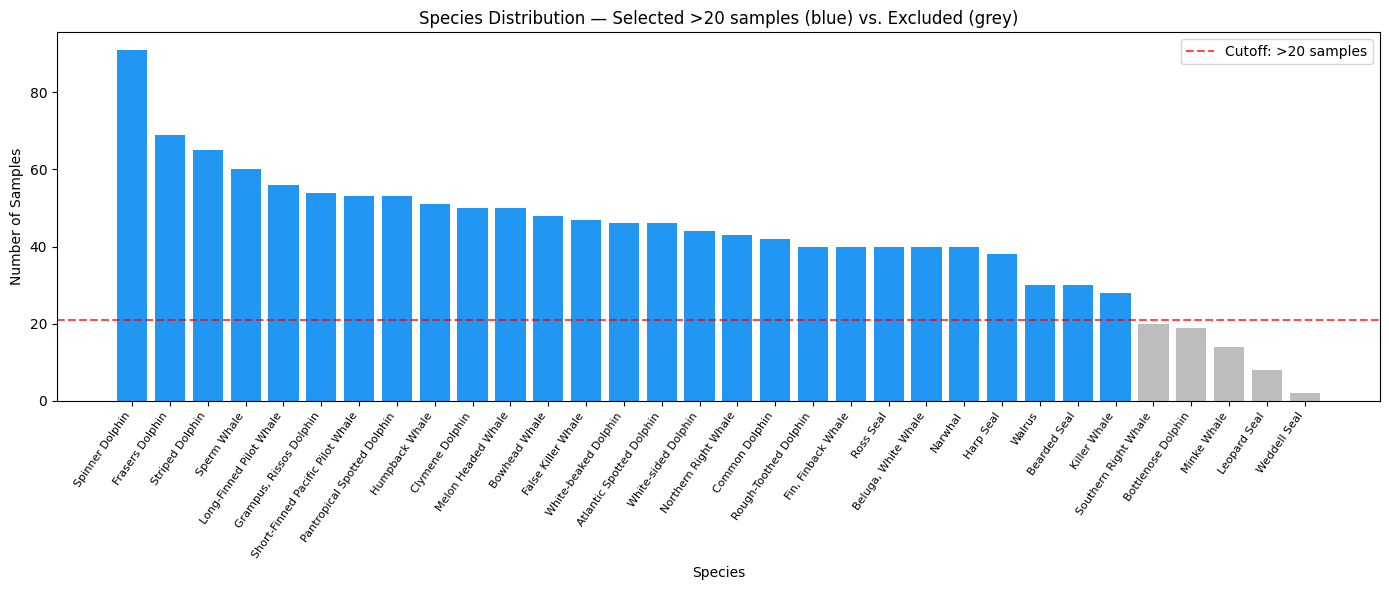


✅ 27 species selected (all have >20 samples):
   1. Spinner_Dolphin                          91 samples
   2. Frasers_Dolphin                          69 samples
   3. Striped_Dolphin                          65 samples
   4. Sperm_Whale                              60 samples
   5. Long-Finned_Pilot_Whale                  56 samples
   6. Grampus,_Rissos_Dolphin                  54 samples
   7. Short-Finned_Pacific_Pilot_Whale         53 samples
   8. Pantropical_Spotted_Dolphin              53 samples
   9. Humpback_Whale                           51 samples
  10. Clymene_Dolphin                          50 samples
  11. Melon_Headed_Whale                       50 samples
  12. Bowhead_Whale                            48 samples
  13. False_Killer_Whale                       47 samples
  14. White-beaked_Dolphin                     46 samples
  15. Atlantic_Spotted_Dolphin                 46 samples
  16. White-sided_Dolphin                      44 samples
  17. Northern_Right_Whal

In [9]:
# Cell 2: Full species distribution (all 32 species)
species_counts = df_train['species'].value_counts()
print(f"Number of species: {len(species_counts)}")
print(f"\nFull distribution:")
print(species_counts.to_string())

# Select species with >20 samples
MIN_SAMPLES = 21
selected_species = species_counts[species_counts >= MIN_SAMPLES].index.tolist()
colors = ['#2196F3' if s in selected_species else '#BDBDBD' for s in species_counts.index]

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(species_counts)), species_counts.values, color=colors)
plt.xticks(range(len(species_counts)), [s.replace('_', ' ') for s in species_counts.index], rotation=55, ha='right', fontsize=8)
plt.title('Species Distribution — Selected >20 samples (blue) vs. Excluded (grey)')
plt.xlabel('Species')
plt.ylabel('Number of Samples')
plt.axhline(y=MIN_SAMPLES, color='red', linestyle='--', alpha=0.7, label=f'Cutoff: >20 samples')
plt.legend()
plt.tight_layout()
plt.savefig('../results/species_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ {len(selected_species)} species selected (all have >{MIN_SAMPLES-1} samples):")
for i, (species, count) in enumerate(species_counts[species_counts >= MIN_SAMPLES].items(), 1):
    print(f"  {i:2d}. {species:40s} {count} samples")

excluded = species_counts[species_counts < MIN_SAMPLES]
print(f"\n❌ {len(excluded)} species excluded (<{MIN_SAMPLES} samples):")
for i, (species, count) in enumerate(excluded.items(), 1):
    print(f"  {i:2d}. {species:40s} {count} samples")

## 🔍 Filter Dataset to Species with >20 Samples

We select the **27 species with more than 20 samples** each, retaining ~95% of the dataset. The 5 excluded species (Weddell Seal: 2, Leopard Seal: 8, Minke Whale: 14, Bottlenose Dolphin: 19, Southern Right Whale: 20) had insufficient samples. Class weights and data augmentation will handle moderate class imbalance.

In [ ]:
# Cell 3: Filter dataset to selected species (>20 samples)
selected_species = species_counts[species_counts >= MIN_SAMPLES].index.tolist()

# Filter both train and test sets
df_train_filtered = df_train[df_train['species'].isin(selected_species)].copy()
df_test_filtered = df_test[df_test['species'].isin(selected_species)].copy()

# Create new label encoding (0-26) for our 27 classes
label_map = {species: idx for idx, species in enumerate(sorted(selected_species))}
df_train_filtered['label'] = df_train_filtered['species'].map(label_map)
df_test_filtered['label'] = df_test_filtered['species'].map(label_map)

print(f"Original train: {len(df_train)} → Filtered train: {len(df_train_filtered)}")
print(f"Original test:  {len(df_test)} → Filtered test: {len(df_test_filtered)}")
print(f"Retained: {len(df_train_filtered)/len(df_train)*100:.1f}% of training data")
print(f"Number of classes: {len(label_map)}")
print(f"\nLabel mapping:")
for species, label in sorted(label_map.items(), key=lambda x: x[1]):
    count = df_train_filtered[df_train_filtered['species'] == species].shape[0]
    print(f"  {label}: {species} ({count} train samples)")

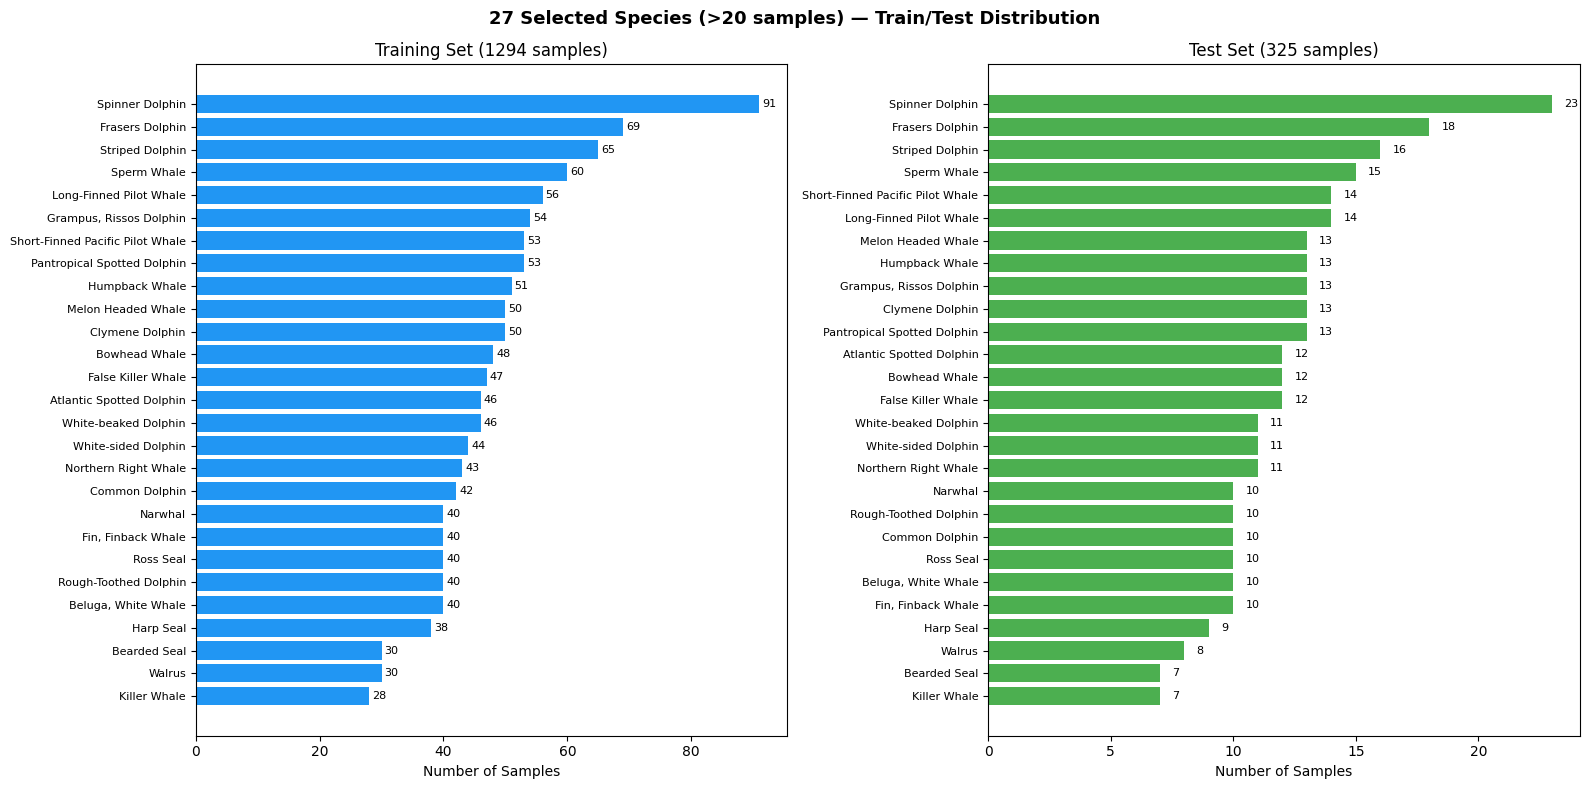


Class balance (train):
  Max: 91 (Spinner_Dolphin)
  Min: 28 (Killer_Whale)
  Ratio max/min: 3.2x


In [10]:
# Cell 4: Visualize filtered distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Train distribution
train_counts = df_train_filtered['species'].value_counts()
axes[0].barh(range(len(train_counts)), train_counts.values, color='#2196F3')
axes[0].set_yticks(range(len(train_counts)))
axes[0].set_yticklabels([s.replace('_', ' ') for s in train_counts.index], fontsize=8)
axes[0].set_xlabel('Number of Samples')
axes[0].set_title(f'Training Set ({len(df_train_filtered)} samples)')
axes[0].invert_yaxis()
for i, v in enumerate(train_counts.values):
    axes[0].text(v + 0.5, i, str(v), va='center', fontsize=8)

# Test distribution
test_counts = df_test_filtered['species'].value_counts()
axes[1].barh(range(len(test_counts)), test_counts.values, color='#4CAF50')
axes[1].set_yticks(range(len(test_counts)))
axes[1].set_yticklabels([s.replace('_', ' ') for s in test_counts.index], fontsize=8)
axes[1].set_xlabel('Number of Samples')
axes[1].set_title(f'Test Set ({len(df_test_filtered)} samples)')
axes[1].invert_yaxis()
for i, v in enumerate(test_counts.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=8)

plt.suptitle('27 Selected Species (>20 samples) — Train/Test Distribution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/selected_species_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Class balance stats
print(f"\nClass balance (train):")
print(f"  Max: {train_counts.max()} ({train_counts.idxmax()})")
print(f"  Min: {train_counts.min()} ({train_counts.idxmin()})")
print(f"  Ratio max/min: {train_counts.max()/train_counts.min():.1f}x")

In [ ]:
# Cell 5: Audio characteristics analysis
# Analyze duration and sample rate across the filtered dataset
durations = []
sample_rates = []

# Use the HuggingFace dataset (not pandas) to access audio arrays
train_dataset = dataset['train']

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    if sample['species'] in selected_species:
        sr = sample['audio']['sampling_rate']
        duration = len(sample['audio']['array']) / sr
        durations.append(duration)
        sample_rates.append(sr)

durations = np.array(durations)
sample_rates = np.array(sample_rates)

print(f"Audio characteristics ({len(selected_species)} selected species):")
print(f"  Sample rates: {np.unique(sample_rates)} Hz")
print(f"  Duration — Mean: {durations.mean():.2f}s, Median: {np.median(durations):.2f}s")
print(f"  Duration — Min: {durations.min():.2f}s, Max: {durations.max():.2f}s")
print(f"  Duration — Std: {durations.std():.2f}s")

# Plot duration distribution
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=50, color='#2196F3', edgecolor='white', alpha=0.8)
plt.axvline(x=np.median(durations), color='red', linestyle='--', label=f'Median: {np.median(durations):.1f}s')
plt.axvline(x=5.0, color='orange', linestyle='--', label='5s (potential target length)')
plt.title(f'Distribution of Audio Clip Durations ({len(selected_species)} Selected Species)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('../results/duration_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

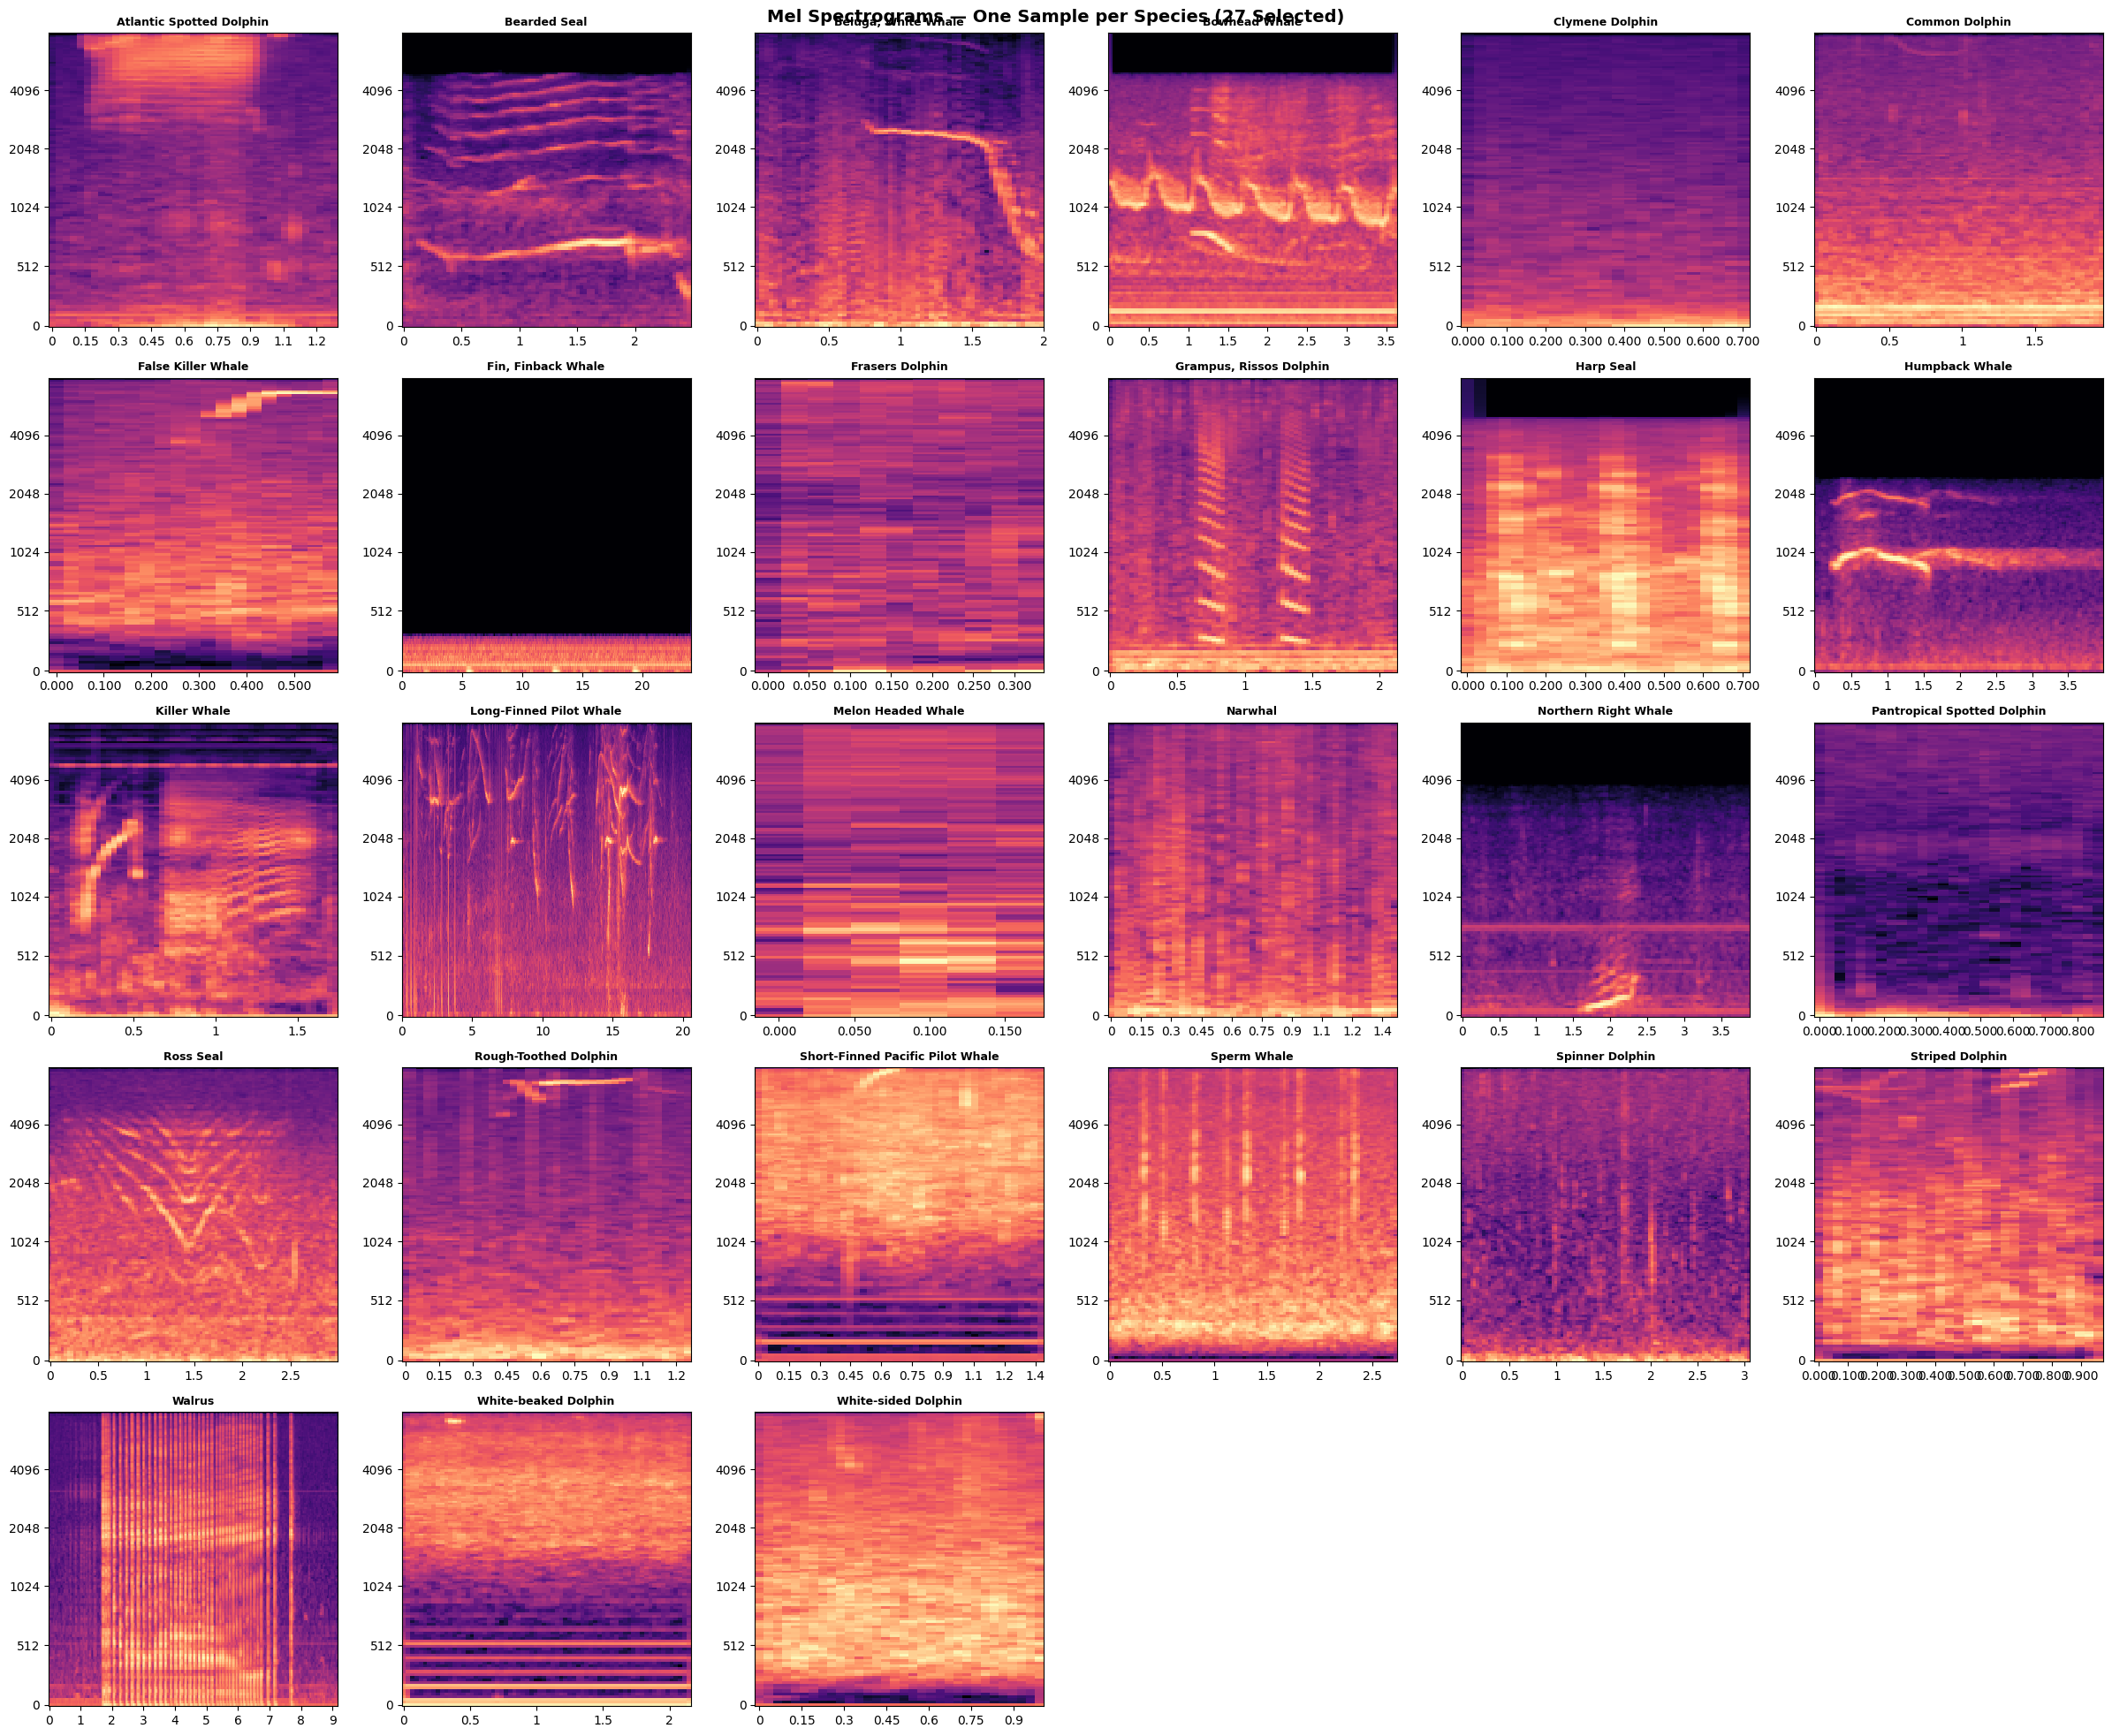

In [11]:
# Cell 6: Visualize one mel-spectrogram per species
import math
n_species = len(selected_species)
n_cols = 6
n_rows = math.ceil(n_species / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4 * n_rows))
axes = axes.flatten()

for idx, species in enumerate(sorted(selected_species)):
    # Find first sample of this species in the dataset
    for i in range(len(train_dataset)):
        if train_dataset[i]['species'] == species:
            sample = train_dataset[i]
            break
    
    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    
    # Generate mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx])
    axes[idx].set_title(species.replace('_', ' '), fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide unused subplots
for idx in range(n_species, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Mel Spectrograms — One Sample per Species ({n_species} Selected)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/sample_spectrograms_all.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔊 Listen to the Species

Play one audio sample from each of the 27 selected species. Press the ▶️ play button to hear what each species sounds like!

In [ ]:
# Cell 6b: Audio playback for all selected species (prefer 10-30s clips)
from IPython.display import display, Audio, HTML

def find_best_sample(dataset, species, target_min=10, target_max=30):
    """Find a sample in the target duration range (10-30s).
    Falls back to the longest available clip if none are in range."""
    best_in_range = None
    best_in_range_dur = 0
    longest = None
    longest_dur = 0
    
    for i in range(len(dataset)):
        sample = dataset[i]
        if sample['species'] != species:
            continue
        sr = sample['audio']['sampling_rate']
        dur = len(sample['audio']['array']) / sr
        
        # Track the longest clip overall as fallback
        if dur > longest_dur:
            longest_dur = dur
            longest = sample
        
        # Prefer clips in the 10-30s sweet spot
        if target_min <= dur <= target_max and dur > best_in_range_dur:
            best_in_range_dur = dur
            best_in_range = sample
    
    if best_in_range is not None:
        return best_in_range
    return longest  # fallback to longest available

for idx, species in enumerate(sorted(selected_species)):
    sample = find_best_sample(train_dataset, species)
    
    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    duration = len(audio) / sr
    
    # Display species name and duration
    range_note = '✅' if 10 <= duration <= 30 else f'⚠️ best available'
    display(HTML(f"<h4>🐋 {idx+1}. {species.replace('_', ' ')} <span style='color:grey; font-size:0.8em'>({duration:.1f}s — {range_note})</span></h4>"))
    
    # Inline audio player
    display(Audio(data=audio, rate=sr))

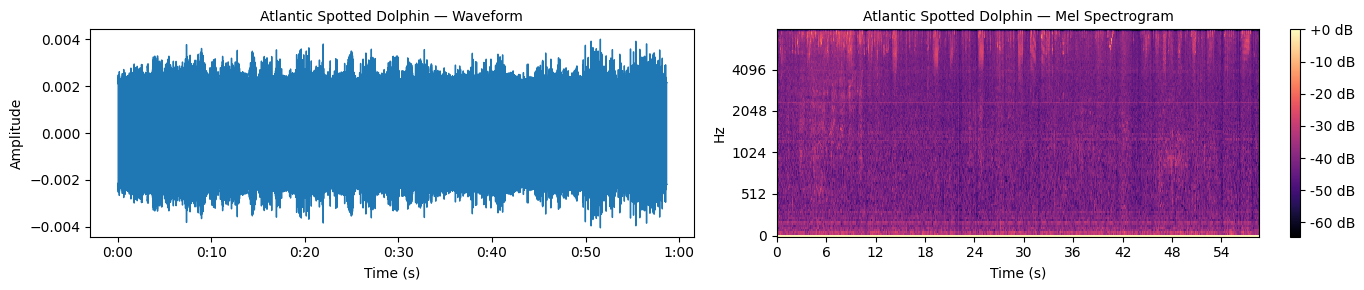

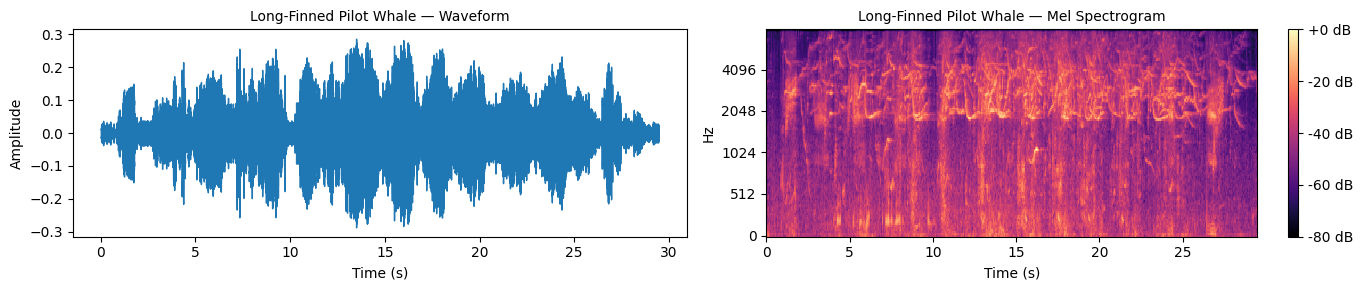

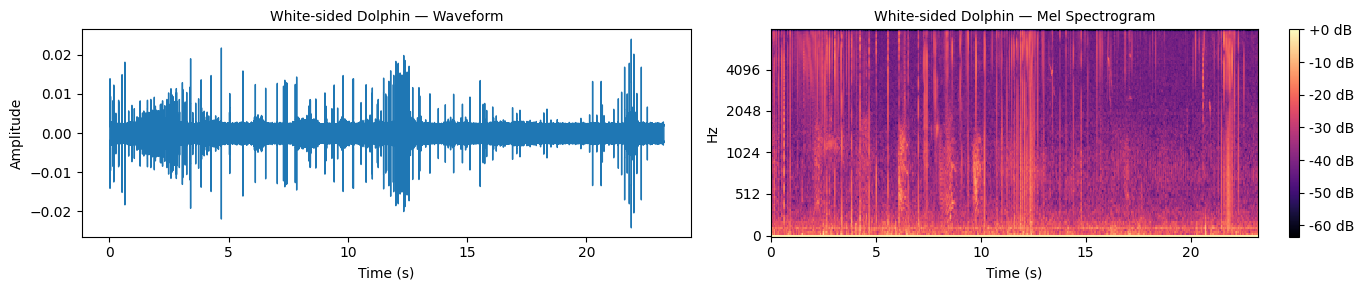

In [12]:
# Cell 7: Waveform + spectrogram comparison for 3 species (with audio)
from IPython.display import display, Audio, HTML

sorted_species = sorted(selected_species)
example_species = [sorted_species[0], sorted_species[len(sorted_species)//2], sorted_species[-1]]

for row, species in enumerate(example_species):
    sample = find_best_sample(train_dataset, species)
    
    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    duration = len(audio) / sr
    
    # Title and audio player
    display(HTML(f"<h4>🔊 {species.replace('_', ' ')} ({duration:.1f}s)</h4>"))
    display(Audio(data=audio, rate=sr))
    
    # Waveform + spectrogram side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 3))
    
    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=axes[0])
    axes[0].set_title(f"{species.replace('_', ' ')} — Waveform", fontsize=10)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title(f"{species.replace('_', ' ')} — Mel Spectrogram", fontsize=10)
    axes[1].set_xlabel('Time (s)')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    if row == len(example_species) - 1:
        plt.savefig('../results/sample_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print()  # spacing between species

## 📊 Summary

**Dataset overview:**
- Original dataset: 32 species, 1,357 train + 340 test samples
- **Filtered dataset: 27 species** with >20 samples each, retaining ~95% of data
- 5 excluded species had insufficient samples for supervised learning
- All audio is sampled at 16 kHz

**Key observations:**
- Class imbalance is moderate (~3.3x ratio between largest and smallest class)
- Class weights and augmentation will be used to handle imbalance
- Audio clip durations vary — we'll need to standardize length during preprocessing
- Mel spectrograms show visually distinct patterns across species → CNN should work well

**Next steps:**
1. Preprocess audio → fixed-length mel spectrograms
2. Build and train a CNN classifier
3. Evaluate on the held-out test set